<a href="https://colab.research.google.com/github/felipsoarez/numerai-colab/blob/main/C%C3%B3pia_de_Numerai_Leaderboard_Viz_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Viz and Analysis on the LeaderBoard
 
I'm Parker Burchett (MrQuantsALot) and created this notebook to figure out if participating in this tournament is the type of challenge I had a reasonable shot at being successful at. 
 
The beautiful thing about blockchain is that since everything is public and anonymous you can just look at the data to get a real answer. After spending a few days writing this, I am pretty sure that I have a reasonable chance and creating a profitable model.
 
I looked at the characteristics and distribution of successful users. 
 
If you have any feedback or suggestions please let me know on the forum. I am still a novice at this kind of analysis and I am sure there are things that I missed or misinterpreted. In particular, I don't know why there is a negative coefficient on the FNC -> 3M_returns OLS regression. 
 
This notebook does the following when you run it:
 
1. Query the [Numerai Leaderboard](https://numer.ai/tournament) and cast it as a Pandas Dataframe.
2. Visualize the relationship between the stake size, performance metrics and returns. 
3. OLS Regression on Returns.  
 
All of the methods are written such that you can change the dependent and independent variables. I included the visualizations I thought were interesting but you can check out the other variables yourself. The numbers will change as the leaderboard updates. 
 

In [1]:
!pip install numpy
!pip install pandas 
!pip install json 
!pip install requests 
!pip install matplotlib
!pip install statsmodels 
%matplotlib inline

ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


# Import packages

In [3]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas.util.testing as tm

# Ping the Leaderboard

In [5]:
def get_leaderboard() -> pd.DataFrame:
    """
        Ping the Numerai leaderboard and return a Pandas DataFrame of the contents.
    """
    url = 'https://api-tournament.numer.ai/'
    # this is a Graphql query, that lets me get exactly and only the data I want. 
    query = """{ 
    v2Leaderboard {
        returns
        corrRep
        fncRep
        mmcRep
        username
        nmrStaked
        returns 
        return_52Weeks
        return_13Weeks
        rank
        }  
    }"""
    r = requests.post(url=url, json={'query': query})
    json_data = json.loads(r.text)
    df_data = json_data['data']['v2Leaderboard']
    df = pd.DataFrame(df_data)
    df.convert_dtypes() # the auto casts the columns into what it thinks is the most appropriate 
    df['nmrStaked'] = pd.to_numeric(df['nmrStaked']) # for some reason nmrStaked does not get auto cast as a numaric
 
    #Renaming the columns
    df = df.rename(columns={'returns': '1D_returns', 'return_13Weeks': '3M_returns', 'return_52Weeks': '1Y_returns'})
    return df
 
df =  get_leaderboard()
print(df.count())
df.head(10)
 
 



corrRep       5476
fncRep        5476
mmcRep        5476
nmrStaked     5476
rank          5476
3M_returns    1934
1Y_returns     401
1D_returns    2645
username      5476
dtype: int64


,corrRep,fncRep,mmcRep,nmrStaked,rank,3M_returns,1Y_returns,1D_returns,username
0,0.053072,0.010245,0.025257,865.901893,1,194.558449,NaN,19.076110,quantyquant
1,0.051262,0.005724,0.024232,1050.581075,2,200.183523,660.512428,21.506273,benben11
2,0.047131,0.021601,0.019748,96.043277,3,62.705261,249.180522,14.564172,labrat
3,0.044944,0.016109,0.025885,0.014615,4,NaN,NaN,11.992405,hb_falcon
4,0.044354,0.013486,0.019788,0.000000,5,NaN,NaN,NaN,uuazed4
5,0.043566,0.007054,0.017754,8.619856,6,109.078930,NaN,1.238475,uuazed6
6,0.043370,0.006939,0.018597,30.531349,7,110.681215,NaN,8.122367,junyou
7,0.042716,0.015993,0.015338,0.000000,8,NaN,NaN,NaN,ezekiel_47_v12
8,0.042480,0.001998,0.029960,1.418858,9,149.586360,NaN,0.285587,neuralnetwork3
9,0.042421,0.006763,0.016724,11.663176,10,121.120547,NaN,-1.286710,uuazed5


# Methods to create plots

### Each method has the optional param min_stake. Use it to exclude smaller stakeing users. 


In [11]:
def create_histogram(df, col='corrRep', bins=50, min_stake=0, max_stake=1000000):
    x = df[((df[col].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][col]
    plt.hist(x, bins, label=f'{col} when nmrStaked>{min_stake}', alpha=.5)
    plt.xlabel(col)
    plt.ylabel('Count')
    num_elements = x.count()    
    return plt
 
def create_scatter_plot(df, x_name='corrRep', y_name='fncRep', min_stake=0, max_stake=1000000):
 
    # these are ugly one liners if you are unfamiliar with pandas.
    # They select a subset of the Dataframe df based on compound booleans. Think of them as SELECT x_name WHERE bool1, bool2... if you were writing SQL
    # (df[x_name].notnull()) get rows when x_name is not null
    # df['nmrStaked'] > min_stake) get rows where the stake is greater than the min_stake
    # df['nmrStaked'] < max_stake) get rows where the stake is less than the max stake
    # [x_name] says only give me the column with name x_name
    x = df[((df[x_name].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][x_name]
    y = df[((df[y_name].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][y_name]
    plt.scatter(x, y, s=.5)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    num_elements = x.count()
    plt.title(
        f'{y_name} v {x_name} when nmrStaked>{min_stake}\n Number of Elements:{num_elements}'
    )
    return plt
 
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (14,7)
plt.rcParams['font.family'] = 'serif'


## Histogram of 3 Month Returns by Stake Size

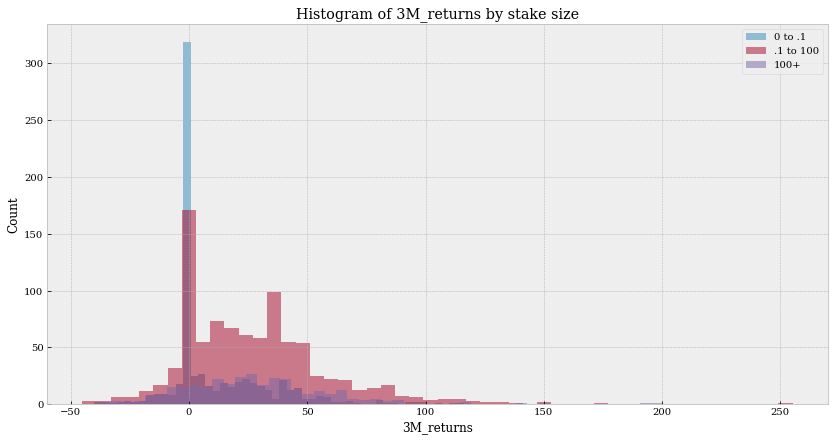

In [14]:
col = '3M_returns' # change this to be '1D_returns' or '1Y_returns' or 'corrRep', 'fncRep' to see other distributions

create_histogram(df,col=col, min_stake=0, max_stake=.1)
create_histogram(df,col=col, min_stake=.1, max_stake=100)
create_histogram(df, col=col,min_stake=100, max_stake=1000000)


plt.legend(['0 to .1','.1 to 100','100+'])
plt.title(f'Histogram of {col} by stake size')
plt.show()

## Histogram of 3 Month returns excluding where stake is < .1

### This excludes everyone that is only betting the free .01 NMR given out. Staking .1 NMR is only about $4 right now so it is not much of a cut off. You can change up these values is reduce who you are looking at. 



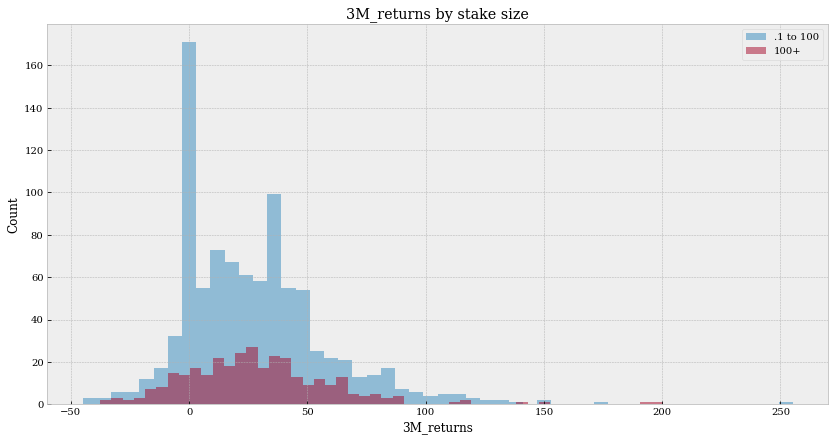

In [13]:
col = '3M_returns'

create_histogram(df,col=col, min_stake=.1, max_stake=100)
create_histogram(df, col=col,min_stake=100, max_stake=1000000)

plt.legend(['.1 to 100','100+'])
plt.title(f'{col} by stake size')
plt.show()

## Histogram of Corr by Stake Size
 
- This forms a bimodal distribution at corrRep = -.1 and corrRep = ~+.025
- I suspect the cluster at exactly corrRep =-.1 is because every score worse than that is recorded as -.1. This would prevent a savvy person from figuring the actual true predictions by submitting a whole bunch of different submissions and then comparing the Corr scores. I don’t know that for certain but it's the best explanation I can think of.


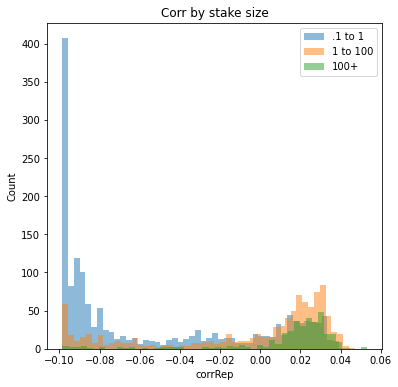

In [ ]:
col = 'corrRep'

create_histogram(df,col=col, min_stake=0, max_stake=1)
create_histogram(df,col=col, min_stake=1, max_stake=100)
create_histogram(df, col=col,min_stake=100, max_stake=1000000)

plt.legend(['.1 to 1','1 to 100','100+'])
plt.title("Corr by stake size")
plt.show()

# Scatter Plots


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

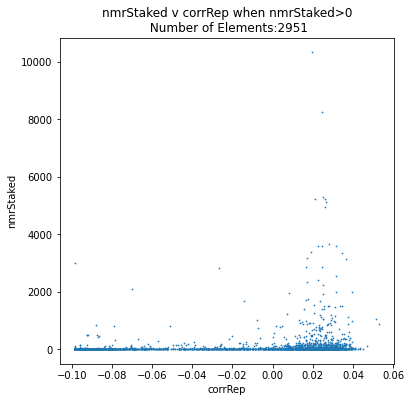

In [ ]:
create_scatter_plot(df, x_name='corrRep', y_name='nmrStaked')

# Methods to for Ordinary Least Squares Regression
 
## [Read about OLS on Wikipedia](https://en.wikipedia.org/wiki/Ordinary_least_squares)
### I am primarily interested in the relationship between stake size and returns. From an economics perspective one would expect people to bet more money on models that have a higher correlation score. This would mean a positive correlation between stake size and returns. 
 



In [ ]:
def compute_single_regression(df,
                              independent_variable='corrRep',
                              dependent_variable='3M_returns',
                              min_stake=0):

    x = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][independent_variable]
    y = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][dependent_variable]
    model = sm.OLS(y, x)
    results = model.fit()
    return results


def compute_multiple_regression(
        df,
        indepenent_variables=['corrRep', 'fncRep', 'mmcRep', 'nmrStaked'],
        dependent_variable='3M_returns',
        min_stake=0):
    x = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][indepenent_variables]
    y = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][dependent_variable]
    model = sm.OLS(y, x)
    results = model.fit()
    return results


## Single Regression Stake Size and 3 Month Returns

In [ ]:
results = compute_single_regression(df,independent_variable='nmrStaked',dependent_variable='3M_returns', min_stake=0)
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             3M_returns   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.025
Method:                 Least Squares   F-statistic:                              49.92
Date:                Thu, 11 Mar 2021   Prob (F-statistic):                    2.23e-12
Time:                        21:26:36   Log-Likelihood:                         -9675.5
No. Observations:                1934   AIC:                                  1.935e+04
Df Residuals:                    1933   BIC:                                  1.936e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nmrStaked      0.0108      0.002      7.065      0.000       0.008       0.014
==============================================================================
Omnibus:                      545.238   Durbin-Watson:                   0.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2232.461
Skew:                           1.311   Prob(JB):                         0.00
Kurtosis:                       7.563   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Findings
 
## There is a small significant positive relationship between amount staked and 3-month returns (coef= 0.0086, p<.000). However, only looking at stake size does not explain much of the variance in the 3-month returns. 
 
- The R^2 value is .027, I thought this would be much larger.
- One explanation is that having access to a lot of capital is not indicative of being good at model building. 
- There are a lot of low capital high skill data scientists out there
 

## Multiple Regression on 1D returns. 
 
### This is looking at the relative impact of CORR, MMC, FNC, and Stake on returns. Because this is only 1D returns one would expect these features to poorly predict returns because there is so much variance in 1D returns. 
 

In [ ]:
# multiple regression looks at the impact of several independent variables on the dependent variable.
# I set the default independent variables to ['corrRep', 'fncRep', 'mmcRep', 'nmrStaked']
results = compute_multiple_regression(df,dependent_variable='1D_returns')
results.summary()
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             1D_returns   R-squared (uncentered):                   0.447
Model:                            OLS   Adj. R-squared (uncentered):              0.447
Method:                 Least Squares   F-statistic:                              480.7
Date:                Thu, 11 Mar 2021   Prob (F-statistic):                   7.74e-304
Time:                        21:26:36   Log-Likelihood:                         -8582.9
No. Observations:                2378   AIC:                                  1.717e+04
Df Residuals:                    2374   BIC:                                  1.720e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep      559.5181     15.065     37.141      0.000     529.977     589.060
fncRep      -539.8582     31.745    -17.006      0.000    -602.109    -477.608
mmcRep       -74.7072     25.306     -2.952      0.003    -124.331     -25.084
nmrStaked   1.892e-05      0.000      0.048      0.962      -0.001       0.001
==============================================================================
Omnibus:                      272.825   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1311.345
Skew:                           0.445   Prob(JB):                    1.76e-285
Kurtosis:                       6.527   Cond. No.                     1.07e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


## Multiple Regression on 3 Month Returns

In [ ]:
results = compute_multiple_regression(df,dependent_variable='3M_returns')
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             3M_returns   R-squared (uncentered):                   0.818
Model:                            OLS   Adj. R-squared (uncentered):              0.817
Method:                 Least Squares   F-statistic:                              2163.
Date:                Thu, 11 Mar 2021   Prob (F-statistic):                        0.00
Time:                        21:26:36   Log-Likelihood:                         -8054.6
No. Observations:                1934   AIC:                                  1.612e+04
Df Residuals:                    1930   BIC:                                  1.614e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep     2610.2455     28.591     91.297      0.000    2554.174    2666.317
fncRep     -3557.5233     61.184    -58.144      0.000   -3677.517   -3437.529
mmcRep       950.8214     46.077     20.636      0.000     860.456    1041.187
nmrStaked  -2.124e-05      0.001     -0.031      0.976      -0.001       0.001
==============================================================================
Omnibus:                      842.621   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19211.722
Skew:                           1.512   Prob(JB):                         0.00
Kurtosis:                      18.141   Cond. No.                     1.15e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multiple Regression on 1 Year Returns

In [ ]:
results = compute_multiple_regression(df, dependent_variable='1Y_returns')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             1Y_returns   R-squared (uncentered):                   0.859
Model:                            OLS   Adj. R-squared (uncentered):              0.858
Method:                 Least Squares   F-statistic:                              605.5
Date:                Thu, 11 Mar 2021   Prob (F-statistic):                   1.80e-167
Time:                        21:26:36   Log-Likelihood:                         -2297.5
No. Observations:                 401   AIC:                                      4603.
Df Residuals:                     397   BIC:                                      4619.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep     9849.8955    311.914     31.579      0.000    9236.687    1.05e+04
fncRep     -2514.7246    699.095     -3.597      0.000   -3889.116   -1140.333
mmcRep     -7398.4412    504.185    -14.674      0.000   -8389.648   -6407.234
nmrStaked      0.0111      0.004      2.894      0.004       0.004       0.019
==============================================================================
Omnibus:                       22.085   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.711
Skew:                           0.403   Prob(JB):                     4.78e-08
Kurtosis:                       4.169   Cond. No.                     2.50e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# What do the long-term profits look like?

In [ ]:
users_with_3_month_returns = df[df['3M_returns'].notnull()]['3M_returns']
num_3M_returns = users_with_3_month_returns.count()
 
print('Description users with 3 months of returns\n', users_with_3_month_returns.describe())
 
users_net_postive_3_month_returns = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 0)]['3M_returns']
num_net_postitive = users_net_postive_3_month_returns.count()
 
percent_net_positive = "{:.1%}".format(num_net_postitive/num_3M_returns)
 
print(f'Users who were net positive over 3 months: {percent_net_positive}')
 
users_net_up_10_percent = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 10)]['3M_returns']
num_net_up_10_percent = users_net_up_10_percent.count()
 
percent_net_up_10 = "{:.1%}".format(num_net_up_10_percent/num_3M_returns)
print(f'Users who were net up 10% over 3 months: {percent_net_up_10}')
 
users_net_up_50_percent = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 50)]['3M_returns']
num_net_up_50_percent = users_net_up_50_percent.count()
 
percent_net_up_50 = "{:.1%}".format(num_net_up_50_percent/num_3M_returns)
print(f'Users who were net up 50% over 3 months: {percent_net_up_50}')

Description users with 3 months of returns
 count    1934.000000
mean       21.794265
std        29.256592
min       -45.050622
25%         0.000000
50%        15.117504
75%        38.236989
max       255.214953
Name: 3M_returns, dtype: float64
Users who were net positive over 3 months: 66.2%
Users who were net up 10% over 3 months: 55.8%
Users who were net up 50% over 3 months: 13.9%


# Conclusions
1. I was surprised that there is a negative relationship between FNC and 3M and 1Y returns. I would have expected each of those parameters to have positive coefficients. 
2. The R^2 increases when you look at larger time frames. This matches intuition and the law of large numbers. As you increase the time period you consider, the randomness in the 1D and 3M returns evens out. 
3. Because there is such a small relationship between stake size and returns, I can conclude that you don't need access to large amounts of capital to build a good model. If you look at the leaderboard right now, there are people who have staked anywhere from 0 to ~1,000 NMR that have similar CORR scores.
4. It seems like betting any amount of money on your model is enough of a signal of confidence in it. There is not that much of a difference between beting 1 and 1000 NMR. This surprised me a lot.
5. Because some people might have multiple accounts, there is an upper bound of ~900 people who have successfully built models to forecast the stock market well enough to get net +10% over three months. That is absolutely incredible. 
 

# Next Steps
 
- Figure out the life cycle of a typical user. How long does it take for them to be profitable, how much turnover is there? How many people just submit the intro model and give up? I am pretty sure I can get this data from the API.
 
- Track these variables over time. I could store the results from the leaderboard every day and then come back in a month and see if it has changed at all.